In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
df

,rownames,crl.tot,dollar,bang,money,n000,make,yesno
0,1,278,0.000,0.778,0.00,0.00,0.00,y
1,2,1028,0.180,0.372,0.43,0.43,0.21,y
2,3,2259,0.184,0.276,0.06,1.16,0.06,y
3,4,191,0.000,0.137,0.00,0.00,0.00,y
4,5,191,0.000,0.135,0.00,0.00,0.00,y
...,...,...,...,...,...,...,...,...
4596,4597,88,0.000,0.000,0.00,0.00,0.31,n
4597,4598,14,0.000,0.353,0.00,0.00,0.00,n
4598,4599,118,0.000,0.000,0.00,0.00,0.30,n
4599,4600,78,0.000,0.000,0.00,0.00,0.96,n


In [3]:
df['spam'] = df['yesno'].replace({'y': 1, 'n': 0})

/var/folders/t1/pt8lfl0s2rz_z_7z9cbm9f5r0000gn/T/ipykernel_37592/3416208827.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['spam'] = df['yesno'].replace({'y': 1, 'n': 0})


In [4]:
df.drop(columns=['rownames', 'yesno'], inplace=True)

In [5]:
features = df.columns[:-1]  
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        feature1 = features[i]
        feature2 = features[j]
        new_feature_name = f"{feature1}_{feature2}"
        df[new_feature_name] = df[feature1] * df[feature2]

In [16]:
x = df.drop(columns=['spam'])
y = df['spam']

Задание 7.4.1
Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?
□	15
□	21
□	20
□	14


In [7]:
#Задание 7.4.2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, 
                                   min_samples_split=2, min_samples_leaf=1, subsample=1,
                                   max_features=None, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(round(accuracy, 3))

0.865


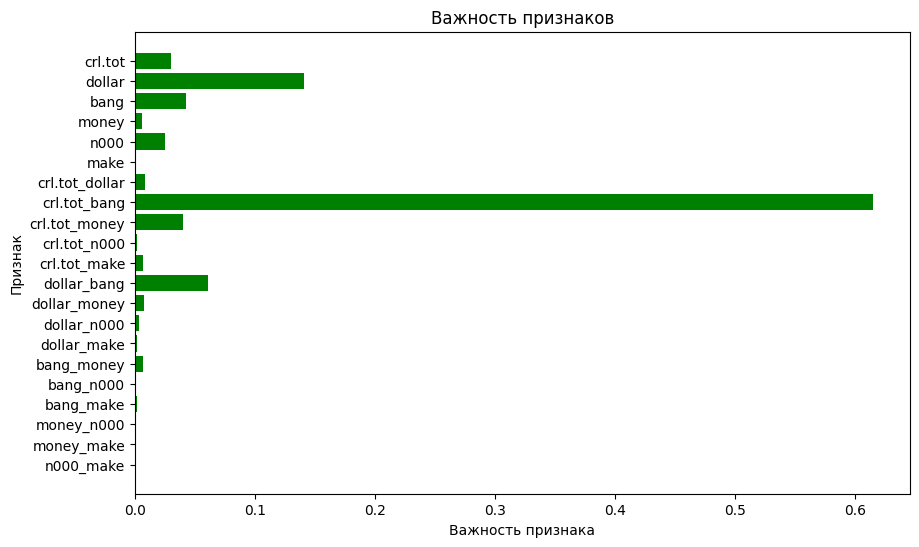

dollar_bang


In [11]:
#Задание 7.4.3
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_

features = x.columns
#вертикальные столбцы
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='g', align='center')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.gca().invert_yaxis()  
plt.show()

third_most_important_feature = features[feature_importance.argsort()[-3]]
print(third_most_important_feature)

In [12]:
#Задание 7.4.4
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(round(best_accuracy, 3))


0.884


Задание 7.4.5
Подбор параметров — незаменимый инструмент при настройке моделей. Однако, если данных очень много, а модель сложная, то иногда имеет смысл ограничить количество параметров, которые вы хотите перебрать. Если модель с одним набором параметров обучается 30 минут, а вы хотите перебрать 10 таких наборов, то стоит приготовиться к пятичасовому ожиданию. Также стоит учитывать, что размер некоторых параметров влияет на время, потраченное на обучение моделей. Например, менее глубокие деревья учатся быстрее, чем глубокие.
При использовании GridSearchCV перебираются все возможные способы комбинации параметров. Сколько разных моделей (моделей градиентного бустинга с разными наборами параметров) обучилось в прошлом задании?


In [13]:
#Задание 7.4.6
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingClassifier(learning_rate=best_params['learning_rate'], 
                                        n_estimators=best_params['n_estimators'], 
                                        random_state=42)

param_grid = {'max_depth': range(5, 16)}

grid_search_depth = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

grid_search_depth.fit(x_train, y_train)

best_depth = grid_search_depth.best_params_['max_depth']
best_depth

5

In [14]:
#Задание 7.4.7
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def AdaBoost_scratch(X, y, M=10, learning_rate=1):
    # Инициализация служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [], [], [], []

    # Инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # Цикл по длине M
    for m in range(M):

        # Обучение базовой модели и получение предсказания
        estimator = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оценка ошибки
        estimator_error = np.sum(sample_weight * incorrect) / np.sum(sample_weight)

        # Вычисление веса нового алгоритма
        estimator_weight = learning_rate * np.log((1 - estimator_error) / estimator_error)

        # Получение новых весов объектов
        sample_weight *= np.exp(estimator_weight * incorrect)

        # Сохранение результатов данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())

    # Для удобства переводим в numpy.array
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получение предсказаний
    preds = (np.array([np.sign((y_predict_list[:, point] * estimator_weight_list).sum()) for point in range(N)]))
    accuracy = (preds == y).sum() / N
    print('Accuracy = ', accuracy)

    return estimator_list, estimator_weight_list, sample_weight_list

# Вызов функции AdaBoost_scratch с использованием предыдущих данных
estimator_list, estimator_weight_list, sample_weight_list = AdaBoost_scratch(x.values, y.values, M=10, learning_rate=0.001)


Accuracy =  0.8228645946533363
